The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Step 0: y_diff_pred = [0.14750875 0.09852758], diff Cz-Czr: [0.14750875 0.09852758], diff Cxdiff: [0.14750875 0.09852758]
Step 1: y_diff_pred = [0.016513   0.00338403], diff Cz-Czr: [0.016513   0.00338403], diff Cxdiff: [0.016513   0.00338403]
Step 2: y_diff_pred = [-0.02149856 -0.04480359], diff Cz-Czr: [-0.02149856 -0.04480359], diff Cxdiff: [-0.02149856 -0.04480359]
Step 3: y_diff_pred = [-0.04516303 -0.04549438], diff Cz-Czr: [-0.04516303 -0.04549438], diff Cxdiff: [-0.04516303 -0.04549438]
Step 4: y_diff_pred = [-0.05158159 -0.05618219], diff Cz-Czr: [-0.05158159 -0.05618219], diff Cxdiff: [-0.05158159 -0.05618219]
Step 5: y_diff_pred = [-0.04730368 -0.0588899 ], diff Cz-Czr: [-0.04730368 -0.0588899 ], diff Cxdiff: [-0.04730368 -0.0588899 ]
Step 6: y_diff_pred = [-0.03832429 -0.05145195], diff Cz-Czr: [-0.03832429 -0.05145195], diff Cxdiff: [-0.03832429 -0.05145195]
Step 7: y_diff_pred = [-0.02

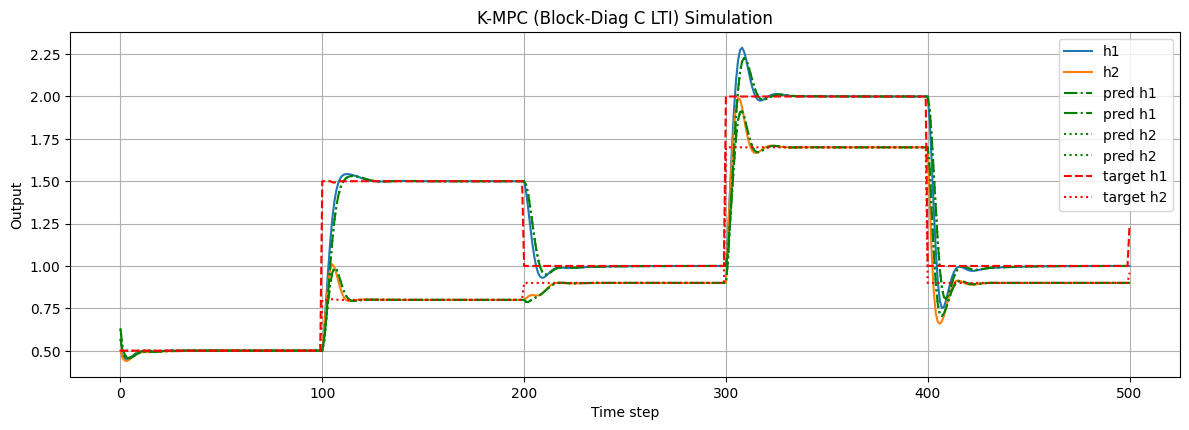

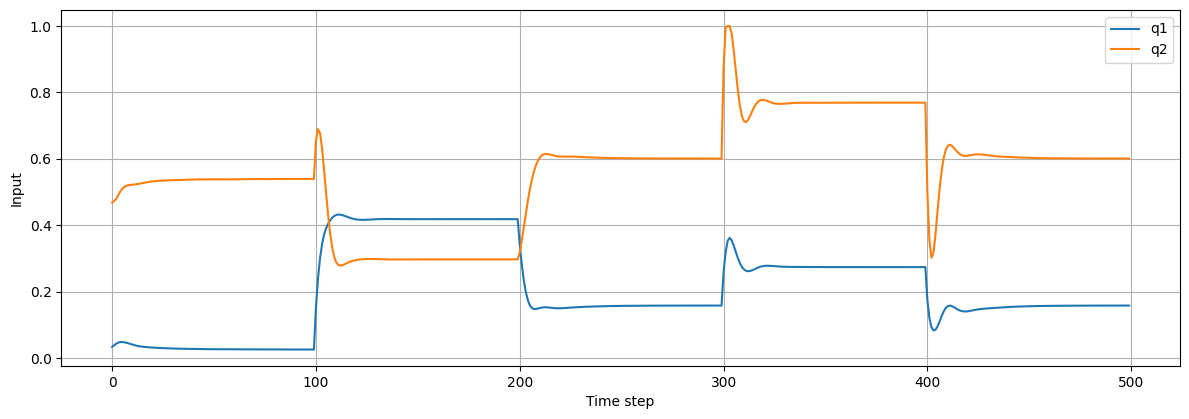

In [52]:
# %matplotlib inline

import sys
from pathlib import Path

import joblib
import numpy as np
import matplotlib.pyplot as plt
import os

# Optional deps used in helper/model stack
import torch  # noqa: F401
import cvxpy as cp  # noqa: F401

# neuromancer symbols are imported in notebook; here they are required indirectly via helper/models loading
from neuromancer.modules import blocks  # type: ignore
from neuromancer.system import Node, System  # type: ignore
from neuromancer.problem import Problem  # type: ignore

# Use already-imported PenaltyLoss, Tuple, inv

# --------------------------- Repository paths ---------------------------------

def get_repo_root() -> Path:
    # In notebook, set repo root manually or relative to notebook
    return Path(".").resolve()

def get_figures_dir(repo_root: Path) -> Path:
    figures = repo_root / "figures"
    figures.mkdir(parents=True, exist_ok=True)
    return figures

REPO_ROOT = get_repo_root()
SRC_PATH = REPO_ROOT / 'src'
if SRC_PATH.as_posix() not in sys.path:
    sys.path.append(SRC_PATH.as_posix())

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path)

import models
import helper
%load_ext autoreload
%autoreload 2

# ------------------------------ IO utilities ----------------------------------

def load_matrices_C_variant(data_dir: Path, matrix_C: bool) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    A = np.load((data_dir / f"A_C_{matrix_C}.npy").as_posix())
    B = np.load((data_dir / f"B_C_{matrix_C}.npy").as_posix())
    C = np.load((data_dir / f"C_C_{matrix_C}.npy").as_posix())
    return A, B, C

def load_scalers(data_dir: Path):
    scaler = joblib.load((data_dir / 'scaler.pkl').as_posix())
    scalerU = joblib.load((data_dir / 'scalerU.pkl').as_posix())
    return scaler, scalerU

def load_sim_setup(repo_root: Path):
    control_path = repo_root / 'control' / 'sim_setup.pkl'
    control_py_path = repo_root / 'control_python' / 'sim_setup.pkl'
    if control_path.exists():
        return joblib.load(control_path.as_posix())
    if control_py_path.exists():
        return joblib.load(control_py_path.as_posix())
    return joblib.load('sim_setup.pkl')

# ------------------------------ CT helpers ------------------------------------

def build_encoders_decoders(ny: int, nz: int, nu: int, matrix_C: bool):
    layers = [20, 40, 60]
    layers_dec = [60, 40, 20]

    # output encoder f_y
    f_y = blocks.MLP(
        ny,
        nz,
        bias=True,
        linear_map=torch.nn.Linear,
        nonlin=torch.nn.ReLU,
        hsizes=layers,
    )
    encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
    encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

    # input encoder f_u representing B
    f_u = torch.nn.Linear(nu, nz, bias=False)
    encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

    # decoder
    if not matrix_C:
        f_y_inv = blocks.MLP(
            nz, ny, bias=True, linear_map=torch.nn.Linear, nonlin=torch.nn.ELU, hsizes=layers_dec
        )
    elif matrix_C:
        f_y_inv = torch.nn.Linear(nz, ny, bias=False)
    else:
        raise ValueError('matrix_C must be boolean')
    decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

    # Koopman linear K
    K = torch.nn.Linear(nz, nz, bias=False)
    Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')

    dynamics_model = System([Koopman], name='Koopman', nsteps=1)
    nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]
    loss = PenaltyLoss([], constraints=[])
    problem = Problem(nodes, loss)
    return problem

def get_x_from_y(problem, y: np.ndarray) -> np.ndarray:
    x = problem.nodes[0]({"Y0": torch.from_numpy(y).float()})
    return x["x"].detach().numpy().reshape(1, -1).T

def get_y_from_x(problem, x: np.ndarray) -> np.ndarray:
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1, -1)

# ------------------------------ Main routine (inline) ----------------------------------

data_dir = REPO_ROOT / '../data'
figures_dir = get_figures_dir(REPO_ROOT)

# Load matrices for matrix_C=False as in notebook
matrix_C = False
A, B, C = load_matrices_C_variant(data_dir, matrix_C)

nz, nu = B.shape
ny = C.shape[0]

# Disturbance model dimension
F = np.eye(ny)
nd = F.shape[1]

# Block diagonalization
T_real, A_block = helper.ident.real_block_diagonalize(A)

# Apply transformation as in notebook (Cell 6)
A = inv(T_real) @ A @ T_real
B = inv(T_real) @ B
C = C @ T_real

# Koopman enc/dec + problem and load weights
problem = build_encoders_decoders(ny, nz, nu, matrix_C)
problem.load_state_dict(torch.load((data_dir / f'model_C_{matrix_C}.pth').as_posix()), strict=False)

# Load scalers
scaler, scalerU = load_scalers(data_dir)

# Plant model
A1 = 1
A2 = 0.5
k1 = 0.5
k2 = 0.8
TwoTanks = models.TwoTanks(True, A1, A2, k1, k2)

# Sim setup
loaded_setup = load_sim_setup(REPO_ROOT)

y_start = loaded_setup['y_start']
y_setpoint = loaded_setup['reference'][:, 0]
u_previous = loaded_setup['u_previous']

# Initial state estimate includes disturbance
z_est_ = np.hstack(((inv(T_real) @ get_x_from_y(problem, y_start)).T, np.zeros((1, nd))))

P0 = loaded_setup['P0']
Q = loaded_setup['Q']
R = loaded_setup['R']

A_ = np.block([
    [A, np.zeros((nz, nd))],
    [np.zeros((nd, nz)), np.eye(nd)],
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu)),
])
C_ = np.hstack([
    C, np.eye(nd),
])

KF = helper.KF(A_, B_, C_, z_est_, P0, Q, R)

# Target calc
target_estimation = helper.TargetEstimation(A, B, C)
z_s, y_s = target_estimation.get_target(z_est_[:, nz:], y_setpoint)
z_ref = z_s

# MPC problem
mpc = helper.MPC(A, B, C)
_ = mpc.get_u_optimal(z_est_[:, :nz], z_est_[:, nz:], u_previous, z_ref)

# Closed-loop simulation
sim_time = int(loaded_setup['sim_time'])
Ts = 1

z_sim = np.zeros((nz + nd, sim_time + 1))
y_sim = np.zeros((ny, sim_time + 1))
u_sim = np.zeros((nu, sim_time))
ys_sim = np.zeros((ny, sim_time + 1))
zs_sim = np.zeros((nz, sim_time + 1))

y_sim_descaled = np.zeros((ny, sim_time + 1))
u_sim_descaled = np.zeros((nu, sim_time))

z_sim[:, 0] = z_est_.flatten()
y_sim[:, 0] = y_start.flatten()
ys_sim[:, 0] = y_s
zs_sim[:, 0] = z_s
u_prev = target_estimation.u_s.value

u_sim_descaled[:, 0] = scalerU.inverse_transform(u_sim[:, 0].reshape(1, -1))[0]
y_sim_descaled[:, 0] = scaler.inverse_transform(y_sim[:, 0].reshape(1, -1))[0]

for k in range(0, sim_time):
    idx_prev = max(k - 1, 0)        
    # Target update
    zs_sim[:, k], ys_sim[:, k] = target_estimation.get_target(
        z_sim[nz:, k], loaded_setup["reference"][:, k]
    )

    # MPC
    u_opt = mpc.get_u_optimal(z_sim[:nz, k], z_sim[nz:, k], u_prev, zs_sim[:, k])
    u_sim[:, k] = u_opt
    u_sim_descaled[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1, -1))[0]

    # Plant
    y_sim_descaled[:, k + 1] = TwoTanks.step(
        y_sim_descaled[:, k], u_sim_descaled[:, k].reshape(1, -1), Ts
    )
    y_sim[:, k + 1] = scaler.transform(y_sim_descaled[:, k + 1].reshape(1, -1))[0]

    # Estimation
    z_sim[:, k + 1] = KF.step(u_sim[:, k], y_sim[:, k]).flatten()
    
    u_prev = u_sim[:, k]

# Objective (exact phrase preserved)
y_pred = C@z_sim[:nz, :]+ z_sim[nz:, :]
y_pred_descaled = scaler.inverse_transform(y_pred.T).T

Qu = loaded_setup['Qu']
Qy = loaded_setup['Qy']
objective_value = 0.0
state_error_cost = 0.0
control_increment_cost = 0.0
x_term_total = 0.0
y_term = 0.0
y_term_total = 0.0
for k in range(sim_time):
    y_diff = y_sim[:, k] - loaded_setup['reference'][:, k]
    u_diff = u_sim[:, k] - u_sim[:, k - 1]
    y_term = float(y_diff.T @ Qy @ y_diff)
    u_term = float(u_diff.T @ Qu @ u_diff)
    state_error_cost += y_term
    control_increment_cost += u_term
    objective_value += y_term + u_term

    # Evaluate x_term (latent state error cost)
    Qz = C.T @ Qy @ C
    Qz_psd = Qz + 1e-8 * np.eye(nz)  # ensure PSD
    x_diff = z_sim[:nz, k] - zs_sim[:, k]
    x_term = float(x_diff.T @ Qz_psd @ x_diff)
    x_term_total += x_term
    
    y_diff_pred = y_pred[:, k] - ys_sim[:, k]
    print(f"Step {k}: y_diff_pred = {y_diff_pred}, diff Cz-Czr: {C@z_sim[:nz, k] - C@zs_sim[:, k]}, diff Cxdiff: {C@x_diff}")  # Debug print to trace
    
    y_term = float(y_diff_pred.T @ Qy @ y_diff_pred)
    y_term_total += y_term

print(f"Closed-loop objective function value: {objective_value}")
print(f"State error term: {state_error_cost}")
print(f"Control increment term: {control_increment_cost}")
print(f"Latent state error term (x_term): {x_term_total}")
print(f"Output error term (y_term): {y_term_total}")

# Plots saved to figures/
y_pred = C@z_sim[:nz, :]+ z_sim[nz:, :]
y_pred_descaled = scaler.inverse_transform(y_pred.T).T

fig = plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(y_sim_descaled[0, :], label='h1')
plt.plot(y_sim_descaled[1, :], label='h2')
plt.plot(y_pred_descaled.T, color='green', linestyle='-.', label='pred h1')
plt.plot(y_pred_descaled.T, color='green', linestyle=':', label='pred h2')
plt.plot(scaler.inverse_transform(ys_sim.T).T[0, :], color='red', linestyle='--', label='target h1')
plt.plot(scaler.inverse_transform(ys_sim.T).T[1, :], color='red', linestyle=':', label='target h2')
plt.title('K-MPC (Block-Diag C LTI) Simulation')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
fig.tight_layout()
fig.savefig((figures_dir / 'CT_states.png').as_posix(), dpi=200)

fig2 = plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(u_sim_descaled[0, :], label='q1')
plt.plot(u_sim_descaled[1, :], label='q2')
plt.xlabel('Time step')
plt.ylabel('Input')
plt.legend()
plt.grid(True)
fig2.tight_layout()
fig2.savefig((figures_dir / 'CT_inputs.png').as_posix(), dpi=200)

In [53]:
y_pred = C@z_sim[:nz, :] + z_sim[nz:, :]
Qu = loaded_setup['Qu']
Qy = loaded_setup['Qy']
objective_value = 0.0
state_error_cost = 0.0
control_increment_cost = 0.0
x_term_total = 0.0
y_term = 0.0
y_term_total = 0.0
for k in range(sim_time):
    y_diff = y_sim[:, k] - loaded_setup['reference'][:, k]
    u_diff = u_sim[:, k] - u_sim[:, k - 1]
    y_term = float(y_diff.T @ Qy @ y_diff)
    u_term = float(u_diff.T @ Qu @ u_diff)
    state_error_cost += y_term
    control_increment_cost += u_term
    objective_value += y_term + u_term

    # Evaluate x_term (latent state error cost)
    Qz = C.T @ Qy @ C
    Qz_psd = Qz + 1e-8 * np.eye(nz)  # ensure PSD
    x_diff = z_sim[:nz, k] - zs_sim[:, k]
    x_term = float(x_diff.T @ Qz_psd @ x_diff)
    x_term_total += x_term
    
    y_diff_pred = y_pred[:, k] - ys_sim[:, k]
    print(f"Step {k}: y_diff_pred = {y_diff_pred}, diff Cz-Czr: {C@z_sim[:nz, k] - C@zs_sim[:, k]}, diff Cxdiff: {C@x_diff}")  # Debug print to trace
    
    y_term = float(y_diff_pred.T @ Qy @ y_diff_pred)
    y_term_total += y_term
    
print(f"Closed-loop objective function value: {objective_value}")
print(f"State error term: {state_error_cost}")
print(f"Control increment term: {control_increment_cost}")
print(f"Latent state error term (x_term): {x_term_total}")
print(f"Output error term (y_term): {y_term_total}")

Step 0: y_diff_pred = [0.14750875 0.09852758], diff Cz-Czr: [0.14750875 0.09852758], diff Cxdiff: [0.14750875 0.09852758]
Step 1: y_diff_pred = [0.016513   0.00338403], diff Cz-Czr: [0.016513   0.00338403], diff Cxdiff: [0.016513   0.00338403]
Step 2: y_diff_pred = [-0.02149856 -0.04480359], diff Cz-Czr: [-0.02149856 -0.04480359], diff Cxdiff: [-0.02149856 -0.04480359]
Step 3: y_diff_pred = [-0.04516303 -0.04549438], diff Cz-Czr: [-0.04516303 -0.04549438], diff Cxdiff: [-0.04516303 -0.04549438]
Step 4: y_diff_pred = [-0.05158159 -0.05618219], diff Cz-Czr: [-0.05158159 -0.05618219], diff Cxdiff: [-0.05158159 -0.05618219]
Step 5: y_diff_pred = [-0.04730368 -0.0588899 ], diff Cz-Czr: [-0.04730368 -0.0588899 ], diff Cxdiff: [-0.04730368 -0.0588899 ]
Step 6: y_diff_pred = [-0.03832429 -0.05145195], diff Cz-Czr: [-0.03832429 -0.05145195], diff Cxdiff: [-0.03832429 -0.05145195]
Step 7: y_diff_pred = [-0.02854196 -0.03994296], diff Cz-Czr: [-0.02854196 -0.03994296], diff Cxdiff: [-0.02854196 -

In [47]:
# square sum of u-uprev
u_diff = u_sim
u = np.zeros(sim_time)
for k in range(sim_time):
    if k == 0:
        u_diff = 0
    else:
        u_diff = u_sim[:, k] - u_sim[:, k - 1]
    u[k] = np.sum(u_diff**2)

In [48]:
sum(u)

6.543774500886401

In [49]:
(u_sim[:, 1] - u_sim[:, 0])**2

array([0.0011623 , 0.00028617])

In [50]:
Qu = loaded_setup['Qu']
Qy = loaded_setup['Qy']
objective_value = 0.0
state_error_cost = 0.0
control_increment_cost = 0.0
x_term_total = 0.0
y_term = 0.0
y_term_total = 0.0
for k in range(sim_time):
    y_diff = y_sim[:, k] - loaded_setup['reference'][:, k]
    u_diff = u_sim[:, k] - u_sim[:, k - 1]
    y_term = float(y_diff.T @ Qy @ y_diff)
    u_term = float(u_diff.T @ Qu @ u_diff)
    state_error_cost += y_term
    control_increment_cost += u_term
    objective_value += y_term + u_term

    # Evaluate x_term (latent state error cost)
    Qz = C.T @ Qy @ C
    Qz_psd = Qz + 1e-8 * np.eye(nz)  # ensure PSD
    x_diff = z_sim[:nz, k] - zs_sim[:, k]
    x_term = float(x_diff.T @ Qz_psd @ x_diff)
    x_term_total += x_term
    
    y_diff_pred = y_pred[:, k] - ys_sim[:, k]
    #print(f"Step {k}: y_diff_pred = {y_diff_pred}, diff Cz-Czr: {C@z_sim[:nz, k] - C@zs_sim[:, k]}, diff Cxdiff: {C@x_diff}")  # Debug print to trace
    
    y_term = float(y_diff_pred.T @ Qy @ y_diff_pred)
    y_term_total += y_term

print(f"Closed-loop objective function value: {objective_value}")
print(f"State error term: {state_error_cost}")
print(f"Control increment term: {control_increment_cost}")
print(f"Latent state error term (x_term): {x_term_total}")
print(f"Output error term (y_term): {y_term_total}")

Closed-loop objective function value: 118.18946092687398
State error term: 80.94049312111173
Control increment term: 37.24896780576214
Latent state error term (x_term): 99.62753674070397
Output error term (y_term): 209.0176391673309
